## Experimental feature: Combo node layout

In [1]:
import sys
import altair as alt
import networkx as nx
import numpy as np
import pandas as pd
from faker import Faker

".." not in sys.path and sys.path.append("..")
from alph import alph, layers, layout, util

util.set_altair_renderer()

Let's generate some data:

- a graph made up of interaction patterns
- some fake names
- a centrality measure
- a couple of categories - jobs and countries


In [2]:
seed = 321
np_random = np.random.RandomState(seed)
Faker.seed(seed)
fake = Faker("en_uk")

jobs = [fake.job() for _ in range(8)]
countries = [fake.country() for _ in range(4)]

G = util.generate_interaction_graph(
    nodes=list("abcdefghijklmnopqrstuvwxyz"), mean_time_between_interactions=1, seed=seed
)

nx.set_node_attributes(G, {
    n: {
        "id": n,
        "name": fake.first_name(),
        "job": np_random.choice(jobs),
        "country": np_random.choice(countries, p=[0.4, 0.3, 0.2, 0.1]),
    } for n in G.nodes()
})
nx.set_node_attributes(G, nx.degree_centrality(G), "degree_centrality")

print(f"G: {len(G.nodes)} node(s), {len(G.edges)} edge(s)")

G: 26 node(s), 39 edge(s)


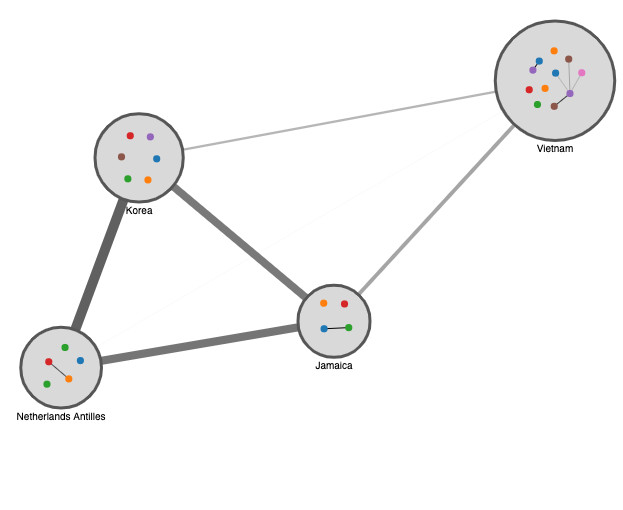

In [5]:
alph(
    G,
    weight_attr="weight",
    combo_group_by="country",
    combo_layout_fn=lambda G: layout.force_atlas(
        G, weight_attr="weight", gravity=1, seed=seed
    ),
    node_args=dict(        
        fill=alt.Color("job", scale=alt.Scale(scheme="category10"), legend=None),
        tooltip_attrs=["name", "job", "country"],
        strokeWidth=0,
    ),
    combo_node_args=dict(
        tooltip_attrs=["country:N"],
        label_attr="country:N",
        label_offset=9,
    ),
    combo_node_additional_attrs={
        country: {"country": country}  for country in countries
    },
    combo_inner_graph_scale_factor=0.5,
    width=600,
    height=500,
).configure_view(strokeWidth=0)

Larger combo with some missing categories

In [7]:
more_countries = [
    None,   # let some nodes have no country
    *[fake.country() for _ in range(15)]
]

G2 = util.generate_interaction_graph(
    nodes=[fake.name() for _ in range(100)], mean_time_between_interactions=1, seed=seed
)

nx.set_node_attributes(G2, {
    n: {
        "id": n,
        "name": fake.first_name(),
        "country": np_random.choice(more_countries),
    } for n in G2.nodes()
})

print(pd.Series([d for _, d in G2.nodes(data="country")]).value_counts(dropna=False)[:3])

Qatar                         10
NaN                            9
Slovakia (Slovak Republic)     9
dtype: int64


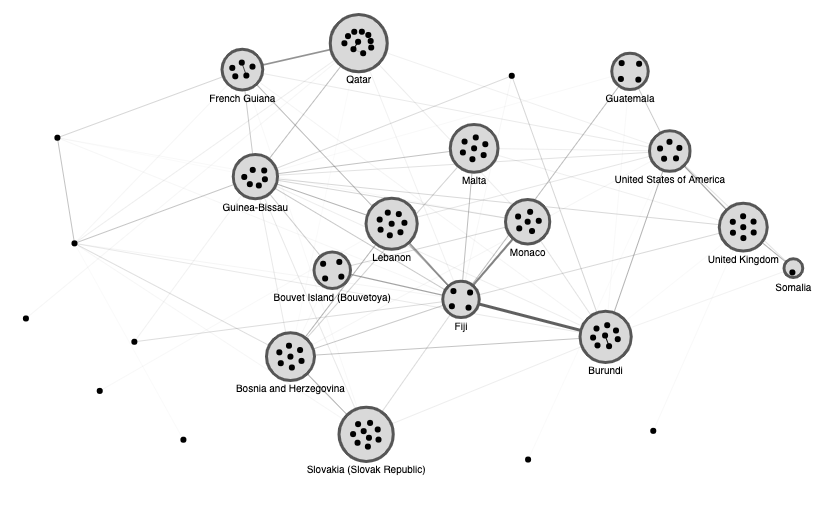

In [9]:
alph(
    G2,
    weight_attr="weight",
    node_args=dict(
        size=36,
        strokeWidth=0,
        tooltip_attrs=["name", "country"],
    ),
    combo_group_by="country",
    combo_layout_fn=lambda G: layout.force_atlas(
        G,
        weight_attr="weight",
        strongGravityMode=True,
        gravity=1,
        edgeWeightInfluence=1.2,
        seed=seed,
    ),
    combo_node_additional_attrs={
        country: {"country": country or ""} for country in more_countries
    },
    combo_node_args=dict(
        tooltip_attrs=["country:N"],
        label_attr="country:N",
        label_offset=12,
    ),
    combo_edge_args=dict(
        strokeWidth=alt.Size("weight", scale=alt.Scale(range=[0.1, 3]), legend=None),
    ),
    combo_size_scale_range=[6**2,90**2],
    combo_inner_graph_scale_factor=0.5,
    combo_empty_attr_action="promote",
    width=800,
    height=500,
).configure_view(strokeWidth=0)